In [1]:
%matplotlib inline

In [29]:
import pandas as pd
import networkx as nx
import itertools
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv('test_SyncDiagnosis.csv')
df["DiagnosisDescription"] = df["DiagnosisDescription"].map(str.strip)

In [34]:
df.head()

,DiagnosisGuid,PatientGuid,ICD9Code,DiagnosisDescription,StartYear,StopYear,Acute,UserGuid
0,AD58C335-C62E-4E4C-A5C9-00005C89DA06,44C0A13A-C841-4063-A2A7-CFADA3785F23,V70.0,Routine general medical examination at a healt...,2010,NaN,0,7511BCEC-9E46-4808-99A7-5B30778B6E84
1,74D1CE08-CD1E-4199-86D3-0001AED0AB24,F2B45907-C559-4077-B2FE-04F354DAB00D,719.45,Pain in joint involving pelvic region and thigh,0,NaN,0,4773B833-9CD4-41E8-895B-846DC1EA7279
2,AFFFEAEF-B454-4FC5-869D-00075A844CEB,1BB806A8-87EE-42B4-960B-5035E84A03C1,780.60,"Fever, unspecified",0,NaN,0,86ACD71A-7F64-43EA-8772-EAD4E1FEF45E
3,11C037C5-0388-4FDB-B777-0007BB0CC51A,CFD993EE-32AD-4A19-821C-71A0438074A6,272.4,Other and unspecified hyperlipidemia,0,NaN,0,2103028E-E805-4F50-A280-407DC423400B
4,F5076968-D5D2-41C9-9C1C-000B8C16CC9D,633FE254-009D-481C-9A3C-8610B2121D0F,465.9,Acute upper respiratory infections of unspecif...,2011,NaN,0,FE52114B-620C-454E-BACA-0B0C7BDF3F32


In [35]:
df.count()

DiagnosisGuid           47911
PatientGuid             47911
ICD9Code                47911
DiagnosisDescription    47911
StartYear               47911
StopYear                 2432
Acute                   47911
UserGuid                47911
dtype: int64

In [36]:
grouping = df.groupby(['PatientGuid', 'DiagnosisDescription'])
df_processed = grouping.count()['DiagnosisGuid'].to_frame().reset_index().drop('DiagnosisGuid', 1)

In [68]:
current_patient = ''
patient_diagosis_dict = {}
for record in df_processed.head(5000).iterrows():
    patient = record[1]['PatientGuid']
    diagnosis = record[1]['DiagnosisDescription']
    
    if patient != current_patient:
        current_patient = patient
        patient_diagosis_dict[current_patient] = [diagnosis]
    else:
        patient_diagosis_dict[current_patient] += [diagnosis]

In [69]:
G = nx.Graph()
for patient in patient_diagosis_dict.keys():
    diagnosis = patient_diagosis_dict[patient]
    edges = list(itertools.combinations(diagnosis, 2))
    for edge in edges:
        u = edge[0]
        v = edge[1]
        if (u, v) in G.edges():
            data = G.get_edge_data(u, v)#, key='edge')
            G.add_edge(u, v, key='edge', weight=data['weight']+1)
        else:
            G.add_edge(u, v, key='edge', weight=1)

In [70]:
G.number_of_nodes()

1225

In [71]:
G.number_of_edges()

24917

In [72]:
nx.write_gexf(G, 'net.gexf')

In [73]:
nx.write_gml(G, 'net.gml')

In [74]:
corr = nx.to_pandas_dataframe(G)#.corr()

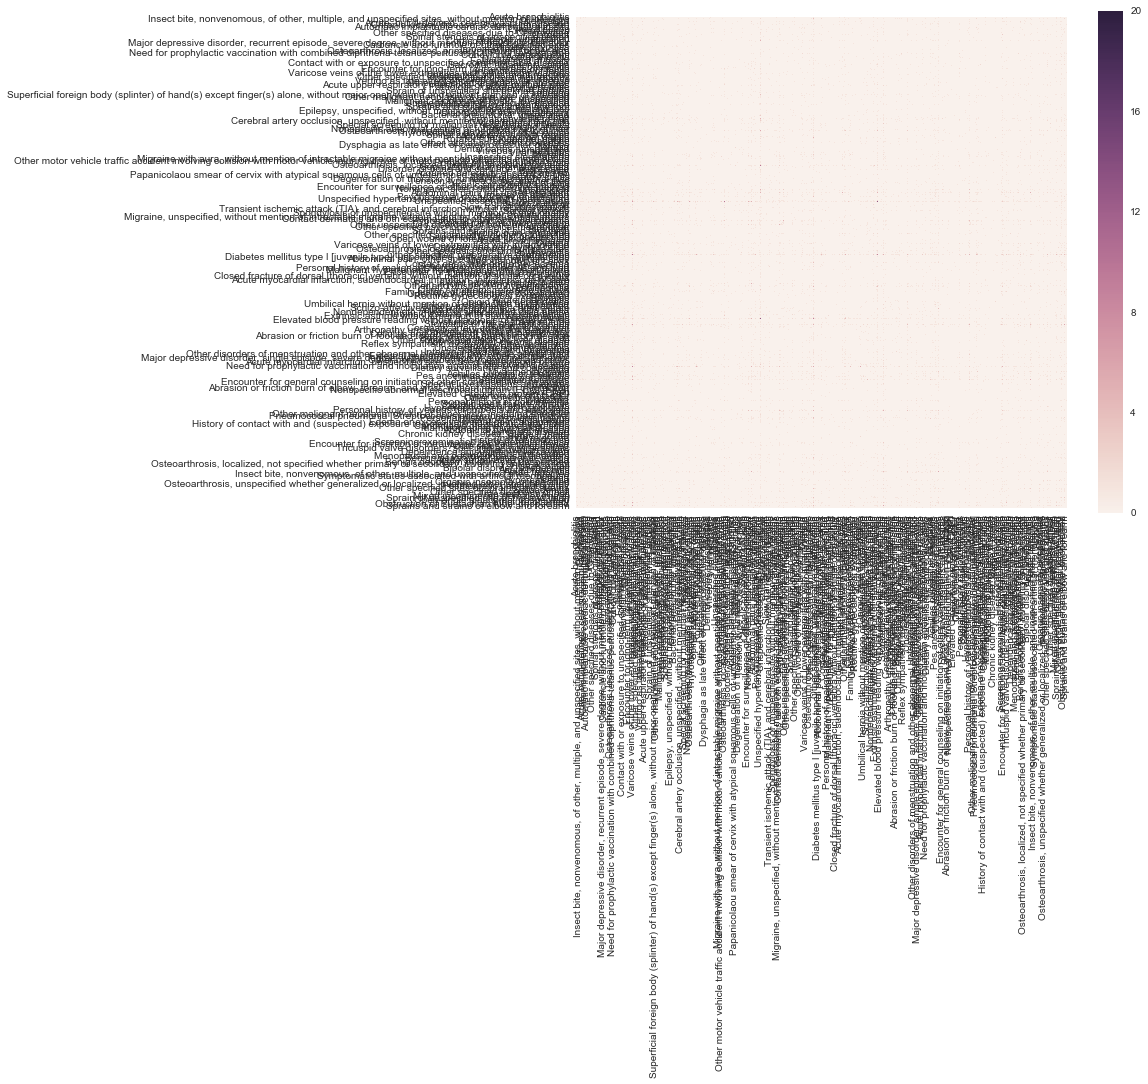

In [75]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, #mask=mask,
            square=True, xticklabels=5, yticklabels=5,
             ax=ax)

In [92]:
corr_short = corr
corr_short['sum'] = corr_short.sum()
corr_short = corr.sort_values('sum', ascending=False).head(50).drop('sum',1)

C:\Users\Alexey\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


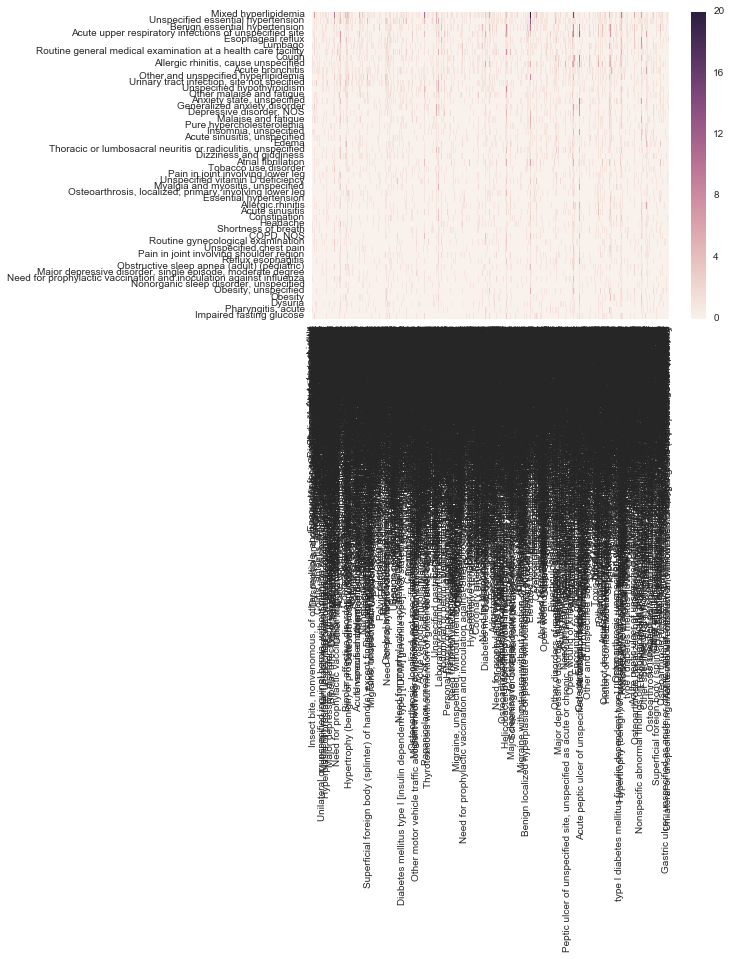

In [90]:
sns.heatmap()

In [111]:
a = corr_short.loc[:, (corr_short > 10).any(axis=0)]

In [112]:
a.sum(axis=0)

Mixed hyperlipidemia                                             238
Acute upper respiratory infections of unspecified site           209
Osteoarthrosis, localized, primary, involving lower leg           76
Obstructive sleep apnea (adult) (pediatric)                       71
Unspecified essential hypertension                               167
Urinary tract infection, site not specified                      107
Allergic rhinitis, cause unspecified                             137
Benign essential hypertension                                    155
Unspecified hypothyroidism                                       137
Routine general medical examination at a health care facility    135
Other malaise and fatigue                                        121
Lumbago                                                          141
Esophageal reflux                                                127
dtype: float64

In [113]:
a

,Mixed hyperlipidemia,Acute upper respiratory infections of unspecified site,"Osteoarthrosis, localized, primary, involving lower leg",Obstructive sleep apnea (adult) (pediatric),Unspecified essential hypertension,"Urinary tract infection, site not specified","Allergic rhinitis, cause unspecified",Benign essential hypertension,Unspecified hypothyroidism,Routine general medical examination at a health care facility,Other malaise and fatigue,Lumbago,Esophageal reflux
Mixed hyperlipidemia,0,1,13,11,19,12,1,1,20,20,15,1,1
Unspecified essential hypertension,19,7,10,4,0,10,1,1,13,1,1,1,1
Benign essential hypertension,1,10,1,1,1,1,12,0,9,6,8,8,7
Acute upper respiratory infections of unspecified site,1,0,3,4,7,8,11,10,3,9,9,12,14
Esophageal reflux,1,14,1,1,1,1,5,7,1,1,1,1,0
Lumbago,1,12,1,1,1,1,7,8,1,1,1,0,1
Routine general medical examination at a health care facility,20,9,1,1,1,1,5,6,1,0,1,1,1
Cough,1,7,1,0,1,1,5,5,1,3,4,10,10
"Allergic rhinitis, cause unspecified",1,11,1,1,1,1,0,12,5,5,6,7,5
Acute bronchitis,1,1,1,1,1,1,1,1,1,1,1,1,1


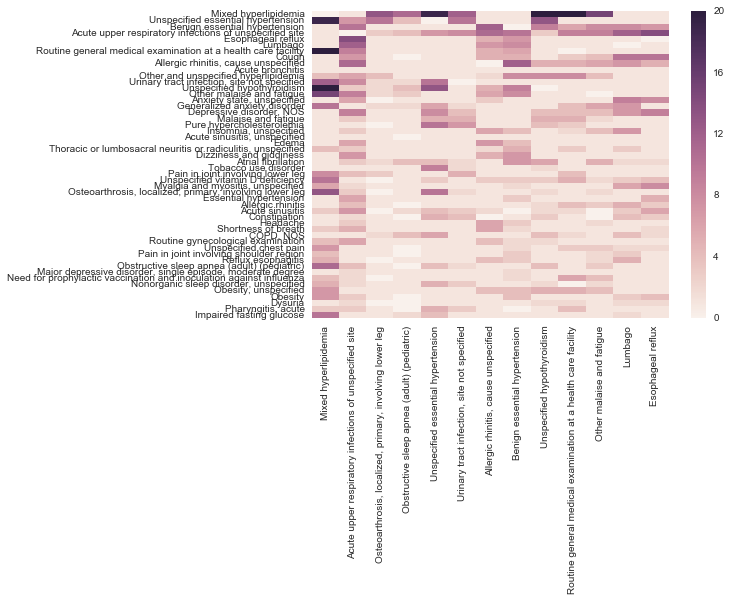

In [114]:
sns.heatmap(a)